In [4]:
import pandas as pd
import argparse
import collections
import csv
import simplejson as json
import random
import gc
import os
import glob
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_colwidth', 0)

import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
#os.chdir("../project3/data/yelp_dataset_2020/selected/Round_3")
#os.chdir(os.getcwd())

#DO NOT RUN
#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#df_scope_elite_19 = pd.concat([pd.read_csv(f, names=['user_id','elite_status']) for f in all_filenames ])
##export to csv
#df_scope_elite_19.to_csv( "yelp_selected_elites.csv", index=False, encoding='utf-8-sig')

In [5]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [3]:
#Randomly Sampled -200000 Users are in both 2017,2018 data or in 2018 but started yelping in 2018
fin_test_yelp_users = pd.read_csv('../project3/groups/fin_test_users.csv')
positive_yelp_users = pd.read_csv('../project3/groups/positive_users.csv',)
sample_yelp_users = pd.read_csv('../project3/groups/sample_users.csv')

fin_test_yelp_users['group'] = 'fin_test_yelp_users'
positive_yelp_users['group'] = 'positive_yelp_users'
sample_yelp_users['group'] = 'sample_yelp_users'

scope_yelp_users = fin_test_yelp_users.append([positive_yelp_users, sample_yelp_users])

In [4]:
df_user_18 = pd.read_csv('../project3/data/yelp_dataset_2019/user.csv')
df_user_18 = df_user_18.reindex(sorted(df_user_18.columns), axis=1)
df_user_18.drop_duplicates(keep=False,inplace=True) 
df_scope_user_18 = scope_yelp_users.merge(df_user_18, left_on='user_id', right_on='user_id').copy()

#del [[df_user_18]]
#gc.collect()

/Users/chen/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_scope_user_18['2018_elite_status'] = df_scope_user_18['elite'].str.contains('2018')
df_scope_user_18['2018_elite_status'].fillna(False, inplace = True)

In [6]:
df_user_18['2018_elite_status'] = df_scope_user_18['elite'].str.contains('2018')
df_user_18['2018_elite_status'].fillna(False, inplace = True)

In [7]:
elite_user_18 = df_user_18[['user_id', '2018_elite_status']]
elite_user_18.set_index('user_id', inplace = True)
elite_user_18_dict = elite_user_18.to_dict()['2018_elite_status']


def get_num_18_elite_friends(flist):
    try:
        return sum(map(lambda x: elite_user_18_dict[x], flist))
    except:
        return 0

In [8]:
df_scope_user_18['friends'] = df_scope_user_18['friends'].apply(lambda x: [i.strip() for i in x.split(',')])
df_scope_user_18['num_2018_elite_friends'] = df_scope_user_18['friends'].apply(get_num_18_elite_friends)


In [19]:
df_scope_user_18['num_2018_elite_friends'].fillna(0, inplace = True)

In [9]:
df_user_18['elite_status'] = df_scope_user_18['elite'].notnull()
elite_user = df_user_18[['user_id', 'elite_status']]
elite_user.set_index('user_id', inplace = True)
elite_user_dict = elite_user.to_dict()['elite_status']


def get_num_elite_friends(flist):
    try:
        return sum(map(lambda x: elite_user_dict[x], flist))
    except:
        return 0

In [13]:
df_scope_user_18['num_elite_friends'] = df_scope_user_18['friends'].apply(get_num_elite_friends)

In [17]:
df_scope_user_18['num_elite_friends'].fillna(0, inplace = True)

In [ ]:
#DEFINTE SELECTED ELITES - not predicting 2019
#df_scope_elite_19 = pd.read_csv('../project3/data/yelp_dataset_2020/selected/Round_3/yelp_selected_elites.csv')
#df_scope_elite_19['2019_elite_status'] = df_scope_elite_19['elite_status'].str.contains('19')
#df_scope_user_18 = df_scope_user_18.merge(df_scope_elite_19, left_on='user_id', right_on='user_id').copy()

#del [[df_scope_elite_19]]
#gc.collect()

In [ ]:
df_scope_review_18 = pd.read_csv('../project3/2018_review.csv')

In [22]:
#2018 RAW
#df_review_18 = pd.read_csv('../project3/data/yelp_dataset_2019/review.csv')
#df_review_18 = df_review_18.reindex(sorted(df_review_18.columns), axis=1)
#df_scope_review_18 = scope_yelp_users.merge(df_review_18, left_on='user_id', right_on='user_id').copy()

#del [[df_review_18]]
#gc.collect()

11

In [23]:
df_scope_review_18.to_csv('../project3/2018_review.csv', index=False, encoding='utf-8-sig')

In [24]:
df_tip_18 = pd.read_csv('../project3/data/yelp_dataset_2019/tip.csv')
df_tip_18 = df_tip_18.reindex(sorted(df_tip_18.columns), axis=1)
df_scope_tip_18 = scope_yelp_users.merge(df_tip_18, left_on='user_id', right_on='user_id').copy()

del [[df_tip_18]]
gc.collect()

0

In [25]:
df_business_18 = pd.read_csv('../project3/data/yelp_dataset_2019/business.csv')
df_scope_tip_business_18 = df_scope_tip_18.merge(df_business_18, how='left', left_on='business_id', right_on='business_id').copy()
df_scope_review_business_18 = df_scope_review_18.merge(df_business_18, how='left', left_on='business_id', right_on='business_id', suffixes=('_review', '_business')).copy()

del [[df_business_18]]
gc.collect()


/Users/chen/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,34,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0

In [26]:
#2017 Yelp Processing
df_user_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_user.csv')
df_user_17 = df_user_17.reindex(sorted(df_user_17.columns), axis=1)
df_user_17.drop_duplicates(keep=False,inplace=True) 
df_scope_user_17 = scope_yelp_users.merge(df_user_17,how='left', left_on='user_id', right_on='user_id').copy()

del [[df_user_17]]
gc.collect()

0

In [ ]:
df_scope_review_17 = pd.read_csv('../project3/2017_review.csv')

In [27]:
#df_review_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_review.csv')
#df_scope_review_17 = scope_yelp_users.merge(df_review_17, left_on='user_id', right_on='user_id').copy()

#del [[df_review_17]]
#gc.collect()

0

In [28]:
#df_scope_review_17.to_csv('../project3/2017_review.csv', index=False, encoding='utf-8-sig')

In [29]:
df_tip_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_tip.csv')
df_scope_tip_17 = scope_yelp_users.merge(df_tip_17, left_on='user_id', right_on='user_id').copy()

del [[df_tip_17]]
gc.collect()

40

In [30]:
df_business_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_business.csv')
df_scope_tip_business_17 = df_scope_tip_17.merge(df_business_17, how='left', left_on='business_id', right_on='business_id').copy()
df_scope_review_business_17 = df_scope_review_17.merge(df_business_17, how='left', left_on='business_id', right_on='business_id',suffixes=('_review', '_business')).copy()

del [[df_business_17]]
gc.collect()

0

In [31]:
df_scope_review_business_17

,user_id,group,review_id,cool,date,stars_review,funny,useful,business_id,text,address,attributes.RestaurantsPriceRange2,attributes.RestaurantsTakeOut,attributes.BestNights,hours.Tuesday,attributes.ByAppointmentOnly,categories,longitude,attributes.NoiseLevel,attributes.Music,attributes.Alcohol,postal_code,attributes.DogsAllowed,name,attributes.DriveThru,attributes.AcceptsInsurance,attributes.RestaurantsTableService,attributes.Smoking,attributes.BYOB,hours.Thursday,hours.Saturday,latitude,attributes.BusinessAcceptsBitcoin,attributes.RestaurantsGoodForGroups,stars_business,attributes.BusinessParking,city,attributes.WheelchairAccessible,attributes,attributes.Ambience,hours.Monday,neighborhood,hours.Friday,state,attributes.HappyHour,hours.Sunday,is_open,attributes.Open24Hours,attributes.GoodForDancing,attributes.RestaurantsCounterService,attributes.Caters,attributes.BusinessAcceptsCreditCards,attributes.AgesAllowed,attributes.RestaurantsAttire,attributes.GoodForKids,hours,attributes.CoatCheck,attributes.BikeParking,attributes.DietaryRestrictions,attributes.WiFi,attributes.Corkage,attributes.OutdoorSeating,attributes.RestaurantsDelivery,attributes.RestaurantsReservations,review_count,attributes.HasTV,attributes.HairSpecializesIn,hours.Wednesday,attributes.GoodForMeal,attributes.BYOBCorkage
0,qwiD67NYQR3PmRg5jnuRdA,fin_test_yelp_users,LXs8kXnQPKxCZffqXG29KA,0,2017-02-25,5,1,0,7tNY4BYLA4laqWNV4IWGQg,"Hands down beats any pie in LV metro. Yes that means you too not so secret pizza and Tony's etc. Superb service also and they don't beat your ass with some overpriced dBag Anthony Bourdain dumpster fire of Kraft veggies and boutique beers and cocktails. Pizza made to order, big enuff for 2...OK, 1 if you are starving like I was when I flew in from Dallas, rented car, drive here and ATE 2 PIES! Did share 1 with wife but almost downed 1.5 pizzas myself and it was awesome awesome awesome. Best bang for pizza buck in 5 counties. Server gal was knowledgeable about pie and Napolitano pie specifically. She is beautiful and smart and nice and quick with the grub!",140 Green Valley Pkwy,2.0,True,NaN,11:0-22:0,NaN,"Restaurants, Pizza",-115.083168,average,NaN,full_bar,89012,False,Settebello Pizzeria Napoletana,NaN,NaN,True,NaN,NaN,11:0-22:0,11:0-22:0,36.022468,NaN,True,4.5,"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",Henderson,True,"{'RestaurantsTableService': 'True', 'GoodForMeal': ""{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'breakfast': False, 'brunch': False}"", 'DogsAllowed': 'False', 'Alcohol': 'full_bar', 'Caters': 'False', 'HasTV': 'True', 'RestaurantsGoodForGroups': 'True', 'NoiseLevel': 'average', 'WiFi': 'no', 'RestaurantsAttire': 'casual', 'RestaurantsReservations': 'False', 'OutdoorSeating': 'True', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsPriceRange2': '2', 'BikeParking': 'True', 'RestaurantsDelivery': 'False', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}"", 'RestaurantsTakeOut': 'True', 'GoodForKids': 'True', 'WheelchairAccessible': 'True', 'BusinessParking': ""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}""}","{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",11:0-22:0,NaN,11:0-22:0,NV,NaN,11:0-22:0,1,NaN,NaN,NaN,False,True,NaN,casual,True,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0', 'Friday': '11:0-22:0', 'Wednesday': '11:0-22:0', 'Thursday': '11:0-22:0', 'Sunday': '11:0-22:0', 'Saturday': '11:0-22:0'}",NaN,True,NaN,no,NaN,True,False,False,901,True,NaN,11:0-22:0,"{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'breakfast': False, 'brunch': False}",NaN
1,qwiD67NYQR3PmRg5jnuRdA,fin_test_yelp_users,jSsE9-FQMdx2TOQgIFC74Q,0,2016-07-18,4,0,0,81ZnnowfL55L3MH-bGpanA

In [ ]:
#df_scope_tip_business_18
#df_scope_review_business_18
#df_scope_user_18
#df_scope_tip_business_17
#df_scope_review_business_17
#df_scope_user_17

In [ ]:
#2017 RAW
#df_review_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_review.csv', nrows=1000)
#df_user_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_user.csv', nrows=1000)
#df_tip_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_tip.csv', nrows=1000)
#df_business_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_business.csv', nrows=1000)
#df_checkin_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_checkin.csv', nrows=1000)

In [ ]:
#df_scope_tip_business_18
#df_scope_review_business_18
#df_scope_user_18

In [32]:
df_scope_tip_18['date'] = pd.to_datetime(df_scope_tip_18['date']) 
df_scope_tip_17_18 = df_scope_tip_18[(df_scope_tip_18['date'].dt.year == 2018) | (df_scope_tip_18['date'].dt.year == 2017)]
df_scope_tip_17_18['count_words'] = df_scope_tip_17_18['text'].apply(lambda x: len(str(x).split(' ')))
df_scope_tip_17_18['count_chars'] = df_scope_tip_17_18['text'].str.len()


grouped_df_scope_tip_17_18 = df_scope_tip_17_18.groupby([df_scope_tip_17_18['date'].dt.year, df_scope_tip_17_18['user_id']]) \
       .agg({'compliment_count':'sum', 'count_words':'mean','count_chars':'mean'}) \
       .rename(columns={'compliment_count':'num_compliment','count_words':'mean_compliment_num_word','count_chars':'mean_compliment_num_chars'}) \
       .reset_index() \
       .sort_values(['user_id','date'],ascending=False)


/Users/chen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
flat_grouped_df_scope_tip_17_18 = grouped_df_scope_tip_17_18.pivot(index='user_id',\
                                                                                           columns='date'
                                                                                          ).reset_index()
flat_grouped_df_scope_tip_17_18.columns = flat_grouped_df_scope_tip_17_18.columns.map('{0[0]}_{0[1]}'.format) 

In [34]:
flat_grouped_df_scope_tip_17_18.rename(columns={'user_id_':'user_id'}, inplace=True)
flat_grouped_df_scope_tip_17_18.fillna(0, inplace=True)

In [40]:
#flat_grouped_df_scope_tip_17_18.to_csv('../project3/flat_grouped_df_scope_tip_17_18.csv', index=False, encoding='utf-8-sig')

flat_grouped_df_scope_tip_17_18 = pd.read_csv('../project3/flat_grouped_df_scope_tip_17_18.csv)



In [44]:
flat_grouped_df_scope_tip_17_18

,user_id,num_compliment_2017,num_compliment_2018,mean_compliment_num_word_2017,mean_compliment_num_word_2018,mean_compliment_num_chars_2017,mean_compliment_num_chars_2018
0,--2HUmLkcNHZp0xw6AMBPg,1.0,0.0,9.641026,4.500000,50.692308,25.500000
1,--BumyUHiO_7YsHurb9Hkw,0.0,0.0,0.000000,15.000000,0.000000,80.000000
2,--KKFIKZpMeRy8fLNp0brA,0.0,0.0,13.000000,0.000000,77.000000,0.000000
3,--b3iokqilK_yZo_pSg3Zg,0.0,0.0,0.000000,21.000000,0.000000,125.000000
4,--lxIKA120M07cOUs8tzZQ,0.0,0.0,3.000000,0.000000,25.000000,0.000000
...,...,...,...,...,...,...,...
19277,zyg4-MFtfPWmwucVazSjfw,0.0,0.0,19.733333,11.666667,103.700000,64.666667
19278,zzFZC9NIXVUgNWYyDFyq-g,0.0,0.0,0.000000,13.000000,0.000000,62.000000
19279,zzVGOFsIjStuFsy_kyJnIg,0.0,0.0,25.000000,0.000000,139.000000,0.000000
19280,zzaq5Fn1U2Feut3dGxidNg,0.0,0.0,13.000000,0.000000,82.000000,0.000000


In [36]:
#engineer reviews 2018
df_scope_review_business_18['date'] = pd.to_datetime(df_scope_review_business_18['date']) 
df_scope_review_business_18['count_words'] = df_scope_review_business_18['text'].apply(lambda x: len(str(x).split(' ')))
df_scope_review_business_18['count_chars'] = df_scope_review_business_18['text'].str.len()
df_scope_review_business_18['user_to_mean_variance'] = (df_scope_review_business_18['stars_business'] - df_scope_review_business_18['stars_review'])**2
df_scope_review_business_18['categories'] = df_scope_review_business_18['categories'].astype(str)



In [37]:
df_scope_review_business_17_18 = df_scope_review_business_18[(df_scope_review_business_18['date'].dt.year == 2018) | (df_scope_review_business_18['date'].dt.year == 2017)]


In [38]:
grouped_df_scope_review_business_17_18 = df_scope_review_business_17_18.groupby([df_scope_review_business_17_18['date'].dt.year,df_scope_review_business_17_18['user_id']]) \
       .agg({'review_id':'count', 'count_words':'mean','count_chars':'mean', 'user_to_mean_variance': 'mean',\
             'categories': ','.join}) \
       .rename(columns={'review_id':'num_reviews','count_words':'mean_review_num_word','count_chars':'mean_review_num_chars',\
                        'user_to_mean_variance':'mean_review_varience', 'categories': 'unique_categories'}) \
       .reset_index() \
       .sort_values(['user_id','date'],ascending=False)


In [39]:
flat_grouped_df_scope_review_business_17_18 = grouped_df_scope_review_business_17_18.pivot(index='user_id',\
                                                                                           columns='date'
                                                                                          ).reset_index()
flat_grouped_df_scope_review_business_17_18.columns = flat_grouped_df_scope_review_business_17_18.columns.map('{0[0]}_{0[1]}'.format) 

In [41]:
flat_grouped_df_scope_review_business_17_18.rename(columns={'user_id_':'user_id'}, inplace=True)
#flat_grouped_df_scope_review_business_17_18.fillna(0, inplace = True)
#flat_grouped_df_scope_review_business_17_18
flat_grouped_df_scope_review_business_17_18['unique_categories_2018']=flat_grouped_df_scope_review_business_17_18['unique_categories_2018'].\
apply(lambda x: len(np.unique(np.array([i.strip() for i in x.split(",")]))) if pd.notnull(x) else None
     )
flat_grouped_df_scope_review_business_17_18['unique_categories_2017']=flat_grouped_df_scope_review_business_17_18['unique_categories_2017'].\
apply(lambda x: len(np.unique(np.array([i.strip() for i in x.split(",")]))) if pd.notnull(x) else None
     )
flat_grouped_df_scope_review_business_17_18.fillna(0, inplace = True)


In [42]:
#flat_grouped_df_scope_review_business_17_18.to_csv('../project3/flat_grouped_df_scope_review_business_17_18.csv', index=False, encoding='utf-8-sig')

flat_grouped_df_scope_review_business_17_18 = pd.read_csv('../project3/flat_grouped_df_scope_review_business_17_18.csv)



In [113]:
#df_scope_user_18['friends'].map(lambda x: len([i.strip() for i in x.split(",")]) if pd.notnull(x) else None)
#map(lambda x: len([i.strip() for i in str(x).split(",")]) if pd.notnull(x) else None)
df_scope_user_18['friends'].replace('None',np.NaN,inplace=True)

def sum_friends(flist):
    try:
        return sum(map(lambda x: 1 if str(x) != 'None' or str(x) != NaN else 0, flist))
    except:
        return 0

df_scope_user_18['num_friends'] = df_scope_user_18['friends'].apply(sum_friends)
    

In [115]:
#engineer user 2018
df_scope_user_18['friends'].replace('None',np.NaN,inplace=True)
df_scope_user_18['2017_elite_status'] = df_scope_user_18['elite'].str.contains('2017')
df_scope_user_18['num_years_elite'] = df_scope_user_18['elite'].map(lambda x: len([i.strip() for i in str(x).split(",")]) if pd.notnull(x) else None)
#df_scope_user_18['elite'].fillna(0, inplace=True)
df_scope_user_18['num_compliments'] = df_scope_user_18[['compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer']].sum(axis=1)
df_scope_user_18['num_votes'] = df_scope_user_18[['cool','funny','useful']].sum(axis=1)
df_scope_user_18['yelping_since'] = pd.to_datetime(df_scope_user_18['yelping_since'])
end_date_18 = pd.to_datetime("12/31/2018")
df_scope_user_18['num_days_acct_created'] = (end_date_18-df_scope_user_18['yelping_since']).dt.days
df_scope_user_18['num_years_elite'].fillna(0, inplace = True) 
df_scope_user_18['2017_elite_status'].fillna(False, inplace = True)
#df_scope_user_18['2017_elite_status'] = df_scope_user_18['2017_elite_status'].astype(int)





In [117]:
df_scope_user_17


user_id                group  average_stars  compliment_cool  compliment_cute  compliment_funny  compliment_hot  compliment_list  compliment_more  compliment_note  compliment_photos  compliment_plain  compliment_profile  compliment_writer   cool elite  fans  \
0       qwiD67NYQR3PmRg5jnuRdA  fin_test_yelp_users  4.14           0.0              0.0              0.0               0.0             0.0              0.0              1.0              0.0                0.0               0.0                 0.0                31.0   None  0.0    
1       p-MUwKepqz9GVXN_TOw6QA  fin_test_yelp_users  5.00           0.0              0.0              0.0               0.0             0.0              0.0              0.0              0.0                0.0               0.0                 0.0                0.0    None  0.0    
2       3SM1prlFXIAw0DSS_HgSzg  fin_test_yelp_users  3.43           0.0              0.0              0.0               1.0             0.0              0.0              0.0              0.0                0.0               0.0                 0.0                144.0  None  1.0    
3       fu3Aeg82ynMB3ZaLkk3L4w  fin_test_yelp_users  3.08           0.0              0.0              0.0               0.0             0.0              0.0              0.0              0.0                0.0               0.0                 0.0                0.0    None  1.0    
4       FFTdfe86jTpYJYkLQTHSHw  fin_test_yelp_users  2.50           0.0              0.0              0.0               0.0             0.0              0.0              0.0              0.0                0.0               0.0                 0.0                0.0    None  0.0    
...                        ...                  ...   ...           ...              ...              ...               ...             ...              ...              ...              ...                ...               ...                 ...                ...     ...  ...    
190036  hSoKKWrNdyRJdNE3--fY9g  sample_yelp_users    3.75           0.0              0.0              0.0               0.0             0.0              0.0              0.0              0.0                0.0               0.0                 0.0                1.0    None  0.0    
190037  efy6pcul86X3T-3pift4tw  sample_yelp_users    4.25           0.0              0.0              0.0               0.0             0.0              0.0              0.0              0.0                0.0               0.0                 0.0                0.0    None  0.0    
190038  N94hjh9yccVjk2bO5a_djg  sample_yelp_users    2.33           0.0              0.0              0.0               0.0             0.0              0.0              1.0              0.0                0.0               0.0                 0.0                0.0    None  0.0    
190039  sEpnZz5EjPxHjL0tBLixOg  sample_yelp_users    1.67           0.0              0.0              0.0               0.0             0.0              0.0              0.0              0.0                0.0               0.0                 0.0                0.0    None  0.0    
190040  Ki8hoAwcO33maqO3yrL79w  sample_yelp_users    5.00           0.0              0.0              0.0               0.0             0.0              0.0              0.0              0.0                0.0               0.0                 0.0                0.0    None  0.0    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [118]:
#engineer user 2017
df_scope_user_17['num_friends'] = df_scope_user_17['friends'].map(lambda x: len([i.strip() for i in x.split(",")]) if pd.notnull(x) else None)
df_scope_user_17['friends'].replace('None',np.NaN,inplace=True)
df_scope_user_17['num_years_elite'] = df_scope_user_17['elite'].map(lambda x: len([i.strip() for i in str(x).split(",")]) if pd.notnull(x) and x != 'None' else 0)
df_scope_user_17['num_compliments'] = df_scope_user_17[['compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer']].sum(axis=1)
df_scope_user_17['num_votes'] = df_scope_user_17[['cool','funny','useful']].sum(axis=1)
end_date_17 = pd.to_datetime("12/31/2017")
df_scope_user_17['num_years_elite'].fillna(0, inplace = True) 



In [122]:
df_scope_user_17_18 = df_scope_user_18.merge(df_scope_user_17, how='inner', left_on='user_id', right_on='user_id',suffixes=('_data_2018', '_data_2017')).copy()
df_scope_user_17_18 = df_scope_user_17_18.merge(flat_grouped_df_scope_review_business_17_18, how='left', left_on='user_id', right_on='user_id')
df_scope_user_17_18 = df_scope_user_17_18.merge(flat_grouped_df_scope_tip_17_18, how='left', left_on='user_id', right_on='user_id', suffixes=('', '_datatip'))
df_scope_user_17_18 = df_scope_user_17_18.reindex(sorted(df_scope_user_17_18.columns), axis=1)



In [20]:
#df_scope_user_17_18.to_csv('../project3/df_scope_user_17_18.csv', index=False, encoding='utf-8-sig')

df_scope_user_17_18 = pd.read_csv('../project3/df_scope_user_17_18.csv')



In [21]:
#SET FEATURES for LOG (No Nulls Allowed)
#df_scope_user_17_18['2019_elite_status'].fillna(False, inplace=True)
df_scope_user_17_18['num_votes_delta'] = df_scope_user_17_18['num_votes_data_2018'] - df_scope_user_17_18['num_votes_data_2017']
df_scope_user_17_18['num_compliments_delta'] = df_scope_user_17_18['num_compliments_data_2018'] - df_scope_user_17_18['num_compliments_data_2017']
df_scope_user_17_18['num_friends_delta'] = df_scope_user_17_18['num_friends_data_2018'] - df_scope_user_17_18['num_friends_data_2017']
df_scope_user_17_18['review_count_delta'] = df_scope_user_17_18['review_count_data_2018'] - df_scope_user_17_18['review_count_data_2017']
df_scope_user_17_18['fans_delta'] = df_scope_user_17_18['fans_data_2018'] - df_scope_user_17_18['fans_data_2017']

#df_scope_user_17_18['_delta'] = df_scope_user_17_18['_2018'] - df_scope_user_17_18['_2017']



In [22]:
df = df_scope_user_17_18

In [9]:
df

2017_elite_status  2018_elite_status  average_stars_data_2017  average_stars_data_2018  compliment_cool_data_2017  compliment_cool_data_2018  compliment_cute_data_2017  compliment_cute_data_2018  compliment_funny_data_2017  compliment_funny_data_2018  compliment_hot_data_2017  compliment_hot_data_2018  compliment_list_data_2017  compliment_list_data_2018  compliment_more_data_2017  compliment_more_data_2018  compliment_note_data_2017  compliment_note_data_2018  \
0       False              False              4.14                     4.14                     0.0                        0                          0.0                        0                          0.0                         0                           0.0                       0                         0.0                        0                          0.0                        0                          1.0                        1                           
1       False              False              5.00                     3.25                     0.0                        0                          0.0                        0                          0.0                         0                           0.0                       0                         0.0                        0                          0.0                        0                          0.0                        0                           
2       False              False              3.43                     3.38                     0.0                        0                          0.0                        0                          0.0                         0                           1.0                       1                         0.0                        0                          0.0                        1                          0.0                        0                           
3       False              False              3.08                     3.08                     0.0                        0                          0.0                        0                          0.0                         0                           0.0                       0                         0.0                        0                          0.0                        0                          0.0                        0                           
4       False              False              2.50                     2.50                     0.0                        0                          0.0                        0                          0.0                         0                           0.0                       0                         0.0                        0                          0.0                        0                          0.0                        0                           
...       ...                ...               ...                      ...                     ...                       ..                          ...                       ..                          ...                        ..                           ...                      ..                         ...                       ..                          ...                       ..                          ...                       ..                           
190036  False              False              3.75                     4.09                     0.0                        0                          0.0                        0                          0.0                         0                           0.0                       0                         0.0                        0                          0.0                        0                          0.0                        0                           
190037  False              False              4.25                     4.70                     0.0                        0                          0.0                        0                      

In [209]:
df['review_count_delta'].fillna(0, inplace = True)
df['num_votes_delta'].fillna(0, inplace = True)
df['num_compliments_delta'].fillna(0, inplace = True)
df['num_years_elite_data_2017'].fillna(0, inplace = True)
df['fans_delta'].fillna(0, inplace = True)
df['average_stars_data_2018'].fillna(0, inplace = True)
df['2017_elite_status'].fillna(0, inplace = True)
df['mean_review_num_chars_2018'].fillna(0, inplace = True)
df['mean_review_num_word_2018'].fillna(0, inplace = True)
df['unique_categories_2018'].fillna(0, inplace = True)

In [18]:
df_test = df[df['group_data_2018'] == 'fin_test_yelp_users']

df_train = df[df['group_data_2018'] != 'fin_test_yelp_users']

In [19]:
x_train = df_train[['review_count_delta','num_votes_delta',
                                                        'num_compliments_delta','num_years_elite_data_2017',
                                                        'fans_delta','average_stars_data_2018','2017_elite_status',
                                                        'mean_review_num_chars_2018','mean_review_num_word_2018','num_days_acct_created',
                                                        'unique_categories_2018','num_elite_friends','review_count_data_2018'
                                                       ]]

y_train = df_train['2018_elite_status']

x_test = df_test[['review_count_delta','num_votes_delta',
                                                        'num_compliments_delta','num_years_elite_data_2017',
                                                        'fans_delta','average_stars_data_2018','2017_elite_status',
                                                        'mean_review_num_chars_2018','mean_review_num_word_2018','num_days_acct_created',
                                                        'unique_categories_2018','num_elite_friends','review_count_data_2018'
                                                       ]]

y_test = df_test['2018_elite_status']


KeyError: "['review_count_delta', 'fans_delta', 'num_votes_delta', 'num_compliments_delta'] not in index"

In [23]:
x_train, x_test, y_train, y_test = train_test_split(df[['review_count_delta','num_votes_delta',
                                                        'num_compliments_delta','num_years_elite_data_2017',
                                                        'fans_delta','average_stars_data_2018','2017_elite_status',
                                                        'mean_review_num_chars_2018','mean_review_num_word_2018','num_days_acct_created',
                                                        'unique_categories_2018','num_elite_friends','review_count_data_2018'
                                                       ]], 
                                                    df['2018_elite_status'], 
                                                    test_size = 0.3, random_state=42)

In [225]:
log = LogisticRegression()
log.fit(x_train, y_train)

/Users/chen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [226]:
y_predict = log.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    log.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)
))

#Accuracy: 0.98523, Precision: 0.84330,   Recall: 0.51378, F1_score: 0.63853 base line
#Accuracy: 0.98618, Precision: 0.81931,   Recall: 0.58465, F1_score: 0.68237 with 2018 mean review counts and word
#Accuracy: 0.98668, Precision: 0.83871,   Recall: 0.58858, F1_score: 0.69173 with num days acct created 2018
#Accuracy: 0.98590, Precision: 0.83832,   Recall: 0.55118, F1_score: 0.66508 with unique categories count


Default threshold:
Accuracy: 0.96613, Precision: 0.93519,   Recall: 0.85771, F1_score: 0.89477


In [ ]:
x_test['pred_y'] = log.predict(x_test)

In [ ]:
x_test = pd.merge(x_test,y_test ,how = 'left',left_index = True, right_index = True)


In [ ]:
df_pred = pd.merge(x_test,df,how = 'left',left_index = True, right_index = True)

In [ ]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, log.predict_proba(x_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [ ]:

plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [ ]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, log.predict_proba(x_test)[:,1])

In [ ]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, log.predict_proba(x_test)[:,1]))

In [ ]:
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['user_id'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='2019_elite_status', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df)

In [24]:
#BOOSTING!

gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=6,
                        objective='binary:logistic', #new objective
                        learning_rate=.045, #.05 
                        subsample=.8, #.8
                        scale_pos_weight = 1,
                        gamma = .5,
                        min_child_weight=3,
                        colsample_bytree=.75        
                       )

eval_set=[(x_train,y_train),(x_test,y_test)]
fit_model = gbm.fit( 
                    x_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test, gbm.predict(x_test, ntree_limit=gbm.best_ntree_limit))

0.9873888411414941

In [25]:

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    accuracy_score(y_test, fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit)),
                    precision_score(y_test, fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit)),
                    recall_score(y_test, fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit)),
                    f1_score(y_test, fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit))
))

#Accuracy: 0.99445, Precision: 0.91354,   Recall: 0.86319, F1_score: 0.88765 without friends
#Accuracy: 0.99460, Precision: 0.91667,   Recall: 0.86614, F1_score: 0.89069 with friends
#Accuracy: 0.99465, Precision: 0.90752,   Recall: 0.87894, F1_score: 0.89300 with varience stat
#Accuracy: 0.99473, Precision: 0.91624,   Recall: 0.87205, F1_score: 0.89360 with category counts
#Accuracy: 0.99473, Precision: 0.91538,   Recall: 0.87303, F1_score: 0.89370
#Accuracy: 0.99498, Precision: 0.91371,   Recall: 0.88583, F1_score: 0.89955
#Accuracy: 0.99515, Precision: 0.91939,   Recall: 0.88681, F1_score: 0.90281
#Accuracy: 0.99520, Precision: 0.91700,   Recall: 0.89173, F1_score: 0.90419

#Accuracy: 0.98685, Precision: 0.95418,   Recall: 0.96822, F1_score: 0.96115
#Accuracy: 0.98725, Precision: 0.95438,   Recall: 0.97043, F1_score: 0.96234




Default threshold:
Accuracy: 0.98739, Precision: 0.95498,   Recall: 0.97064, F1_score: 0.96275


In [ ]:
df[['review_count_delta','num_votes_delta',
                                                        'num_compliments_delta','num_years_elite_data_2017',
                                                        'fans_delta','average_stars_data_2018','2017_elite_status',
                                                        'mean_review_num_chars_2018','mean_review_num_word_2018','num_days_acct_created',
                                                        'unique_categories_2018','num_elite_friends','review_count_data_2018'
                                                       ]], 
                                                    df['2018_elite_status']

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
fit_model, df[['review_count_delta','num_votes_delta',
                                                        'num_compliments_delta','num_years_elite_data_2017',
                                                        'fans_delta','average_stars_data_2018','2017_elite_status',
                                                        'mean_review_num_chars_2018','mean_review_num_word_2018','num_days_acct_created',
                                                        'unique_categories_2018','num_elite_friends','review_count_data_2018'
                                                       ]], df['2018_elite_status'], cv=5, scoring='f1_macro')

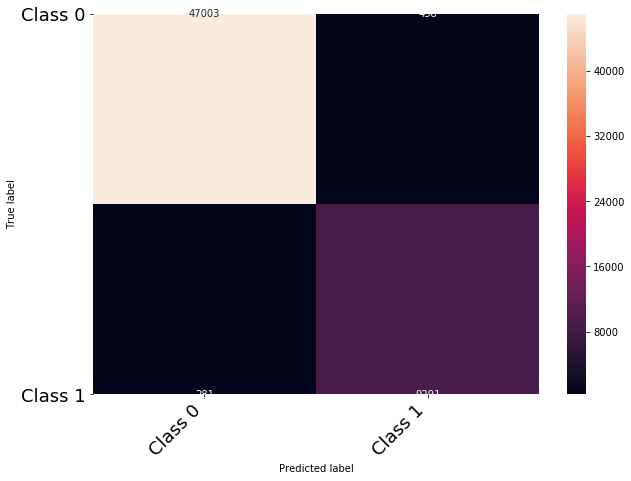

In [26]:
y_pred = fit_model.predict(x_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

In [27]:
conf_mat

array([[47003,   438],
       [  281,  9291]])

In [ ]:
x_test['pred_y'] = gbm.predict(x_test)

In [214]:
x_test['pred_proba'] = gbm.predict_proba(x_test)[:,1]

In [ ]:
x_test = pd.merge(x_test,y_test ,how = 'left',left_index = True, right_index = True)


In [215]:
df_pred = pd.merge(x_test,df,how = 'left',left_index = True, right_index = True)

In [217]:
pd.reset_option('display.max_colwidth')

In [221]:
df_pred[(df_pred['2018_elite_status'] == 1) & (df_pred['pred_proba'] > .5)]

,review_count_delta_x,num_votes_delta_x,num_compliments_delta_x,num_years_elite_data_2017_x,fans_delta_x,average_stars_data_2018_x,2017_elite_status_x,mean_review_num_chars_2018_x,mean_review_num_word_2018_x,num_days_acct_created_x,unique_categories_2018_x,num_elite_friends_x,review_count_data_2018_x,pred_proba,2017_elite_status_y,2018_elite_status,average_stars_data_2017,average_stars_data_2018_y,compliment_cool_data_2017,compliment_cool_data_2018,compliment_cute_data_2017,compliment_cute_data_2018,compliment_funny_data_2017,compliment_funny_data_2018,compliment_hot_data_2017,compliment_hot_data_2018,compliment_list_data_2017,compliment_list_data_2018,compliment_more_data_2017,compliment_more_data_2018,compliment_note_data_2017,compliment_note_data_2018,compliment_photos_data_2017,compliment_photos_data_2018,compliment_plain_data_2017,compliment_plain_data_2018,compliment_profile_data_2017,compliment_profile_data_2018,compliment_writer_data_2017,compliment_writer_data_2018,cool_data_2017,cool_data_2018,elite_data_2017,elite_data_2018,fans_data_2017,fans_data_2018,friends_data_2017,friends_data_2018,funny_data_2017,funny_data_2018,group_data_2017,group_data_2018,mean_compliment_num_chars_2017,mean_compliment_num_chars_2018,mean_compliment_num_word_2017,mean_compliment_num_word_2018,mean_review_num_chars_2017,mean_review_num_chars_2018_y,mean_review_num_word_2017,mean_review_num_word_2018_y,mean_review_varience_2017,mean_review_varience_2018,name_data_2017,name_data_2018,num_2018_elite_friends,num_compliment_2017,num_compliment_2018,num_compliments_data_2017,num_compliments_data_2018,num_days_acct_created_y,num_elite_friends_y,num_friends_data_2017,num_friends_data_2018,num_reviews_2017,num_reviews_2018,num_votes_data_2017,num_votes_data_2018,num_years_elite_data_2017_y,num_years_elite_data_2018,review_count_data_2017,review_count_data_2018_y,unique_categories_2017,unique_categories_2018_y,useful_data_2017,useful_data_2018,user_id,yelping_since_data_2017,yelping_since_data_2018,num_votes_delta_y,num_compliments_delta_y,num_friends_delta,review_count_delta_y,fans_delta_y
59369,106.0,785.0,1.0,3,3.0,4.31,True,752.384615,144.307692,1757,28.0,0.0,314,0.993968,True,True,4.11,4.31,3.0,3,0.0,0,3.0,3,1.0,1,0.0,0,0.0,0,4.0,4,0.0,0,4.0,5,2.0,2,2.0,2,0.0,212,"2015, 2016, 2017","2015,2016,2017,2018",7.0,10,"MfDGBpOHbWdy0KFRe9Y8yQ, JEShDW18_FUeUfSDdq7Iyw...","[GcdYgbaF75vj7RO6EZhPOQ, G0Mu95b3NXx3EO7gw6B1Z...",0.0,167,fin_test_yelp_users,fin_test_yelp_users,NaN,NaN,NaN,NaN,0.000000,752.384615,0.000000,144.307692,0.000000,2.288462,Matthew,Matthew,0,NaN,NaN,19.0,20,1757,0.0,72.0,81,0.0,13.0,4.0,789,3,4.0,208.0,314,0.0,28.0,4.0,410,2D_f_K3DVHqucxxnBRmaeA,2014-03-09,2014-03-09 05:20:02,785.0,1.0,9.0,106.0,3.0
114828,17.0,63.0,3.0,1,1.0,3.85,True,463.000000,88.666667,1596,17.0,0.0,98,0.989168,True,True,3.74,3.85,1.0,1,0.0,0,1.0,1,0.0,0,0.0,0,0.0,0,0.0,2,1.0,1,0.0,1,1.0,1,1.0,1,0.0,20,2017,"2017,2018",2.0,3,"-xDW3gYiYaoeVASXywTPgw, DLtq8nC4FGW13fO5ii0dCg...","[lt7bNHl-TXziny4FETu8nA, byrFElY8eTy-iF3_4yaE-...",2.0,7,positive_yelp_users,positive_yelp_users,0.00,55.0,0.0,10.0,369.400000,463.000000,74.000000,88.666667,1.150000,0.916667,Renee,Renee,0,0.0,0.0,5.0,8,1596,0.0,4.0,9,5.0,3.0,4.0,67,1,2.0,81.0,98,16.0,17.0,2.0,40,mqw3VRzz6jhmpAzC1dsIyA,2014-08-17,2014-08-17 05:44:08,63.0,3.0,5.0,17.0,1.0
116708,24.0,132.0,1.0,1,0.0,3.99,True,0.000000,0.000000,3524,0.0,0.0,166,0.986341,True,True,3.97,3.99,1.0,1,0.0,0,1.0,1,0.0,0,0.0,0,0.0,0,2.0,2,0.0,0,1.0,2,0.0,0,0.0,0,0.0,47,2017,"2017,2018",3.0,3,"HaIFK1BGC98pucRh0h1tSw, sERqJeKqk4y5yoxXNeRWmg...","[HaIFK1BGC98pucRh0h1tSw, sERqJeKqk4y5yoxXNeRWm...",1.0,18,positive_yelp_users,positive_yelp_users,NaN,NaN,NaN,NaN,248.000000,0.000000,44.000000,0.000000,0.833333,0.000000,Marti,Marti,0,NaN,NaN,5.0,6,3524,0.0,24.0,26,3.0,0.0,10.0,142,1,2.0,142.0,166,11.0,0.0,9.0,77,8I6tUqUTi4xL9j3FuwgjIQ,2009-05-07,2009-05-07 22:17:59,132.0,1.0,2.0,24.0,0.0
111158,44.0,4641.0,648.0,6,52.0,3.82,True,0.000000,0.000000,3215,0.0,0.0,

In [222]:
df_pred[(df_pred['2018_elite_status'] == 0) & (df_pred['pred_proba'] > .5)].sort_values(['pred_proba'],ascending=False)


,review_count_delta_x,num_votes_delta_x,num_compliments_delta_x,num_years_elite_data_2017_x,fans_delta_x,average_stars_data_2018_x,2017_elite_status_x,mean_review_num_chars_2018_x,mean_review_num_word_2018_x,num_days_acct_created_x,unique_categories_2018_x,num_elite_friends_x,review_count_data_2018_x,pred_proba,2017_elite_status_y,2018_elite_status,average_stars_data_2017,average_stars_data_2018_y,compliment_cool_data_2017,compliment_cool_data_2018,compliment_cute_data_2017,compliment_cute_data_2018,compliment_funny_data_2017,compliment_funny_data_2018,compliment_hot_data_2017,compliment_hot_data_2018,compliment_list_data_2017,compliment_list_data_2018,compliment_more_data_2017,compliment_more_data_2018,compliment_note_data_2017,compliment_note_data_2018,compliment_photos_data_2017,compliment_photos_data_2018,compliment_plain_data_2017,compliment_plain_data_2018,compliment_profile_data_2017,compliment_profile_data_2018,compliment_writer_data_2017,compliment_writer_data_2018,cool_data_2017,cool_data_2018,elite_data_2017,elite_data_2018,fans_data_2017,fans_data_2018,friends_data_2017,friends_data_2018,funny_data_2017,funny_data_2018,group_data_2017,group_data_2018,mean_compliment_num_chars_2017,mean_compliment_num_chars_2018,mean_compliment_num_word_2017,mean_compliment_num_word_2018,mean_review_num_chars_2017,mean_review_num_chars_2018_y,mean_review_num_word_2017,mean_review_num_word_2018_y,mean_review_varience_2017,mean_review_varience_2018,name_data_2017,name_data_2018,num_2018_elite_friends,num_compliment_2017,num_compliment_2018,num_compliments_data_2017,num_compliments_data_2018,num_days_acct_created_y,num_elite_friends_y,num_friends_data_2017,num_friends_data_2018,num_reviews_2017,num_reviews_2018,num_votes_data_2017,num_votes_data_2018,num_years_elite_data_2017_y,num_years_elite_data_2018,review_count_data_2017,review_count_data_2018_y,unique_categories_2017,unique_categories_2018_y,useful_data_2017,useful_data_2018,user_id,yelping_since_data_2017,yelping_since_data_2018,num_votes_delta_y,num_compliments_delta_y,num_friends_delta,review_count_delta_y,fans_delta_y
15307,45.0,581.0,19.0,3,7.0,3.17,True,0.000000,0.000000,2418,0.0,0.0,257,0.997946,True,False,3.09,3.17,7.0,13,0.0,0,7.0,13,2.0,5,0.0,0,2.0,3,4.0,6,3.0,3,7.0,7,1.0,2,2.0,2,19.0,147,"2015, 2017, 2016","2015,2016,2017",9.0,16,"BQkC6RneYfvfG6wRe0hsvQ, VeCwvsEdaDjqLKF5Rh80zg...","[Cn1O4lBc2XaLerj7cd0Z2A, YT5pK_8X1EJ8VbpFBBWQB...",9.0,130,fin_test_yelp_users,fin_test_yelp_users,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,Sean,Sean,0,NaN,NaN,35.0,54,2418,0.0,225.0,255,NaN,NaN,54.0,635,3,3.0,212.0,257,NaN,0.0,26.0,358,wsOx40lZIyQoIHuUFuUPNQ,2012-05-17,2012-05-17 03:19:14,581.0,19.0,30.0,45.0,7.0
130441,16.0,-569.0,30.0,3,23.0,3.57,True,1301.444444,232.333333,2603,30.0,0.0,412,0.997794,True,False,3.57,3.57,54.0,58,0.0,0,54.0,58,14.0,20,0.0,1,9.0,10,27.0,30,15.0,20,61.0,62,1.0,5,32.0,33,727.0,705,"2017, 2014, 2013","2013,2014,2017",47.0,70,"WKIW7tWyMq7_XN0V2ouo0A, aqJizYMvNspyxeL01r4Hrw...","[JRxO-Ndjd0vp-MPBFTtNZg, a85qPvr6L63PF0v9Zs8ZA...",116.0,343,sample_yelp_users,sample_yelp_users,NaN,NaN,NaN,NaN,1110.142857,1301.444444,191.714286,232.333333,1.464286,1.305556,Rick,Rick,0,NaN,NaN,267.0,297,2603,0.0,1059.0,1104,7.0,9.0,3097.0,2528,3,3.0,396.0,412,22.0,30.0,2254.0,1480,r_Q6zhem0pJhvLcvp3YTXw,2011-11-14,2011-11-14 00:03:21,-569.0,30.0,45.0,16.0,23.0
146567,16.0,3383.0,10.0,2,17.0,3.82,True,0.000000,0.000000,1413,0.0,0.0,316,0.997607,True,False,3.81,3.82,11.0,12,0.0,0,11.0,12,4.0,5,1.0,1,1.0,1,4.0,4,5.0,7,4.0,7,0.0,0,5.0,7,75.0,1145,"2016, 2017","2016,2017",26.0,43,"OXEb4icixKsbLjEGPSrIAA, uIjj7EIVBU4kGNgmKPO02A...","[90U9Qgse46LfGRP3dGNOgw, ctPsHtkWYv8FgFlycBcf5...",85.0,1115,sample_yelp_users,sample_yelp_users,NaN,NaN,NaN,NaN,1572.666667,0.000000,290.000000,0.000000,1.583333,0.000000,Alyssa,Alyssa,0,NaN,NaN,46.0,56,1413,0.0,153.0,198,3.0,0.0,248.0,3631,2,2.0,300.0,316,24.0,0.0,88.0,1371,gWFbfassLbjkd7nfGPCu9A,2015-02-16,2015-02-16 03:03:47,3383.0,10.0,45.0,16.0,1

In [ ]:
df_scope_review_business_18[df_scope_review_business_18['user_id']=='L_Ft1kZRot-UIlDf6WS9iQ']

# DID NOT USE MODELS

In [263]:
LSVC = LinearSVC()
LSVC.fit(x_train, y_train)
y_pred = LSVC.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))

y_predict = LSVC.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    LSVC.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

#Accuracy: 0.98850, Precision: 0.81027,   Recall: 0.71457, F1_score: 0.75941


0.9721291635241085
Default threshold:
Accuracy: 0.97213, Precision: 0.89776,   Recall: 0.94118, F1_score: 0.91896


/Users/chen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [264]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    knn.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

Default threshold:
Accuracy: 0.94842, Precision: 0.85328,   Recall: 0.83661, F1_score: 0.84486


In [265]:
DT = DecisionTreeClassifier(max_depth=7)
DT.fit(x_train, y_train)
y_predict = DT.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    DT.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

#Accuracy: 0.99375, Precision: 0.88765,   Recall: 0.86319, F1_score: 0.87525 
#Accuracy: 0.99410, Precision: 0.90206,   Recall: 0.86122, F1_score: 0.88117 with category

Default threshold:
Accuracy: 0.98479, Precision: 0.94904,   Recall: 0.96103, F1_score: 0.95500


In [269]:
randomforest = RandomForestClassifier(n_estimators=1000) #100
randomforest.fit(x_train, y_train)

y_predict = randomforest.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    randomforest.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

#Accuracy: 0.99438, Precision: 0.91852,   Recall: 0.85433, F1_score: 0.88526

Default threshold:
Accuracy: 0.98685, Precision: 0.95315,   Recall: 0.96929, F1_score: 0.96115


In [268]:
nb = GaussianNB()
nb.fit(x_train, y_train)

y_predict = nb.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    nb.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))


Default threshold:
Accuracy: 0.96771, Precision: 0.87395,   Recall: 0.94379, F1_score: 0.90753
